# Kaggle NLP series - 2nd Task - Tweet Sentiment Extraction

### Hi Everyone, This is the second notebook in my NLP Kaggle series. In previous notebook we saw a simple toxic comment classification (https://www.kaggle.com/sasidharturaga/eda-step-wise-preprocess-and-lstm-classifier). 
### In this one lets find out the "word or phrase" from the tweet that exemplifies the provided sentiment

# Do upvote if you find this helpful. Let's get started.

### I am going to perform EDA and discuss different methods of tackling the problem

## Brief description about the problem

* A set of sentences and their sentiment labels (postive, negative and neutral) are given.
* The task for us is to identify and extract the part of sentences which are mainly responsible for the sentiment associated with sentence.

### Sentiment classification vs Sentiment Extraction

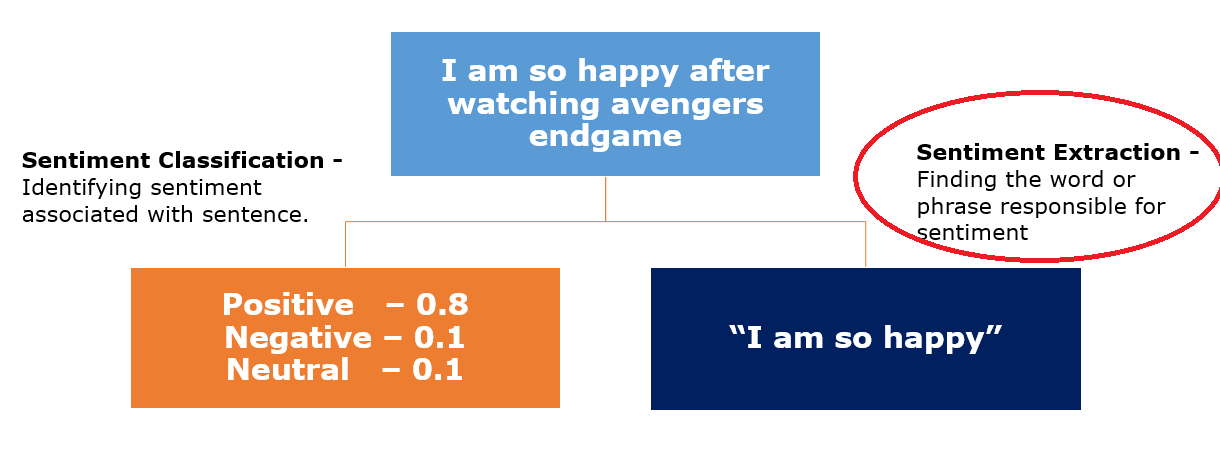

### In our task sentiment labels are given and we have to extract phrases responsible for that sentiment. So, Let's get started

## **Import basic libraries and let's have a look at the data**

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tweet-sentiment-extraction/sample_submission.csv
/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/tweet-sentiment-extraction/test.csv


In [2]:
train=pd.read_csv("/kaggle/input/tweet-sentiment-extraction/train.csv")
test=pd.read_csv("/kaggle/input/tweet-sentiment-extraction/test.csv")
samp_sub=pd.read_csv("/kaggle/input/tweet-sentiment-extraction/sample_submission.csv")
print(train.shape,test.shape)

(27481, 4) (3534, 3)


In [3]:
train.head(3)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative


In [4]:
#checking if there are any empty rows
print(train.isnull().sum()),print(test.isnull().sum())

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64
textID       0
text         0
sentiment    0
dtype: int64


(None, None)

In [5]:
#one missing value in train lets see what it is and remove it
print(train[train.text.isna()])

train.dropna(axis=0,inplace=True)

print(train.shape)

         textID text selected_text sentiment
314  fdb77c3752  NaN           NaN   neutral
(27480, 4)


## Here we have text and sentiment column and we have to predict selected_text column. Now let's do some EDA regarding sentiment distribution and sentence lengths

In [6]:
import plotly.express as px

df1=pd.DataFrame(train["sentiment"].value_counts()).reset_index()
df1["Label"]=df1["index"]
df1["Count of Sentences"]=df1["sentiment"]
df1=df1.sort_values("sentiment", ascending=False)
fig = px.bar(df1, x="Label", y="Count of Sentences", title="No. of sentences per label",color="Count of Sentences",text="Count of Sentences")
fig.update_traces( textposition='outside')
fig.show()

In [7]:
#now lets look at sentence lengths

train['text_lengths'] = train.apply(lambda row: len(row['text'].split(" ")), axis=1)
px.histogram(train['text_lengths'])

### Good, most of the sentences are falling within range 1-40. We cannot remove characters or any non-alphanumeric values from sentence beacuse in the challenge it is clearly mentioned that word or phrase should include all characters within that span (i.e. including commas, spaces, etc.)

### Jaccard score is the evaluating metric for the task. Let's look at an example which explains how jaccard similarity works
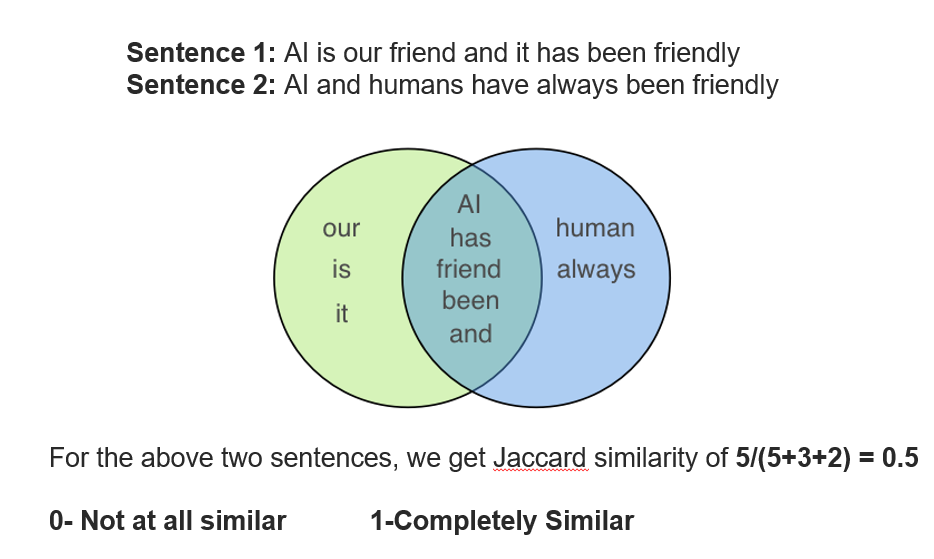

## Now let's look at how jaccard distribution looks like for each sentiment

In [8]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

train["jaccard_score"]= [jaccard(train.at[i,"selected_text"],train.at[i,"text"]) for i in train.index]

## Jaccard distribution for neutral sentiment sentences

In [9]:

df1=train[train["sentiment"]=="neutral"]
px.histogram(df1, x="jaccard_score", color="sentiment")

## From above graphs its is evident that most of the "selected texts" having "neutral" sentiment are the "entire sentences" thats why most of the distribution of jaccard score is near 1.

## Jaccard distribution for positive sentiment sentences

In [10]:
#jaccard distribution for positive
df1=train[train["sentiment"]=="positive"]
px.histogram(df1, x="jaccard_score", color="sentiment")

## Jaccard distribution for neutral sentiment sentences

In [11]:
#jaccard distribution for negative
df1=train[train["sentiment"]=="negative"]
px.histogram(df1, x="jaccard_score", color="sentiment")

## Unlike neutral, "Positive" and "Negative" sentiments have somewat identical distribution of jaccard scores. 



# Now lets discuss in how many ways this problem can be solved

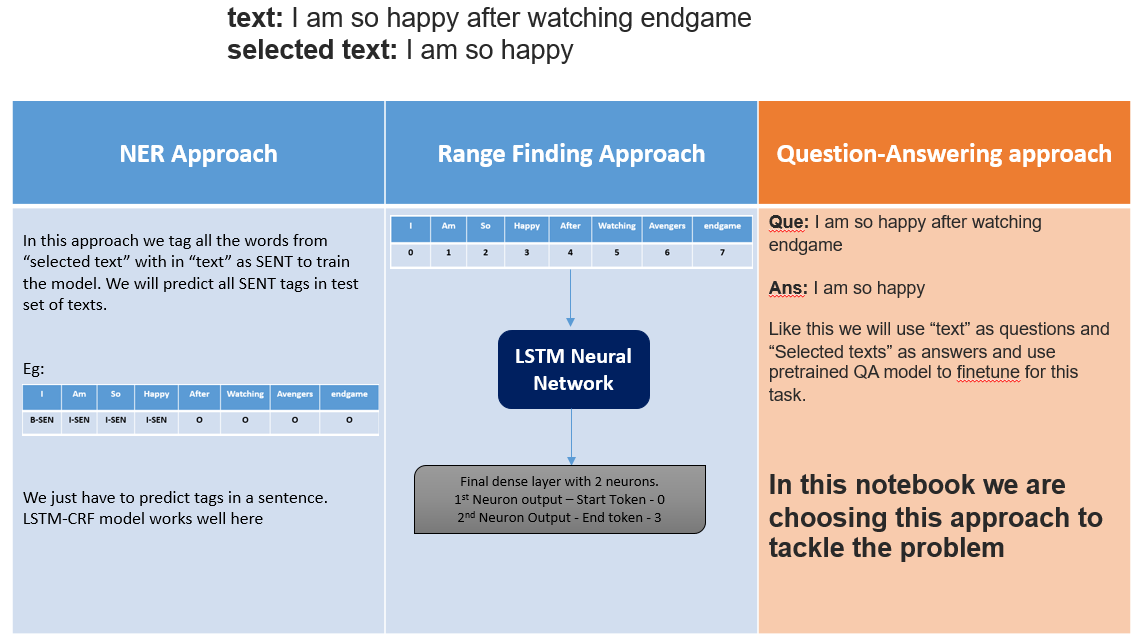

## Data prepration

### Download pretrained RoBERTa tokenizer

In [12]:
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base',add_prefix_space=True)

In [13]:
# converting everythin to lower case
train['text'] = train['text'].apply(lambda x : str(x).lower())
train['selected_text'] = train['selected_text'].apply(lambda x : str(x).lower())

In [14]:
train

,textID,text,selected_text,sentiment,text_lengths,jaccard_score
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,8,1.000000
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,11,0.200000
2,088c60f138,my boss is bullying me...,bullying me,negative,5,0.166667
3,9642c003ef,what interview! leave me alone,leave me alone,negative,6,0.600000
4,358bd9e861,"sons of ****, why couldn`t they put them on t...","sons of ****,",negative,15,0.214286
...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on denver husband l...,d lost,negative,18,0.058824
27477,4f4c4fc327,i`ve wondered about rake to. the client has ...,", don`t force",negative,26,0.083333
27478,f67aae2310,yay good for both of you. enjoy the break - y...,yay good for both of you.,positive,24,0.272727
27479,ed167662a5,but it was worth it ****.,but it was worth it ****.,positive,8,1.000000


## Steps:
### 1) Split the data in to train and validation

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_val , y_train , y_val = train_test_split(train[['text','sentiment']],train['selected_text'],test_size=0.2, random_state=42)
x_train.shape, x_val.shape , y_train.shape , y_val.shape

((21984, 2), (5496, 2), (21984,), (5496,))

### 2) Tokenize data - convert string to list of numbers with pretrained tokenizer 
### 3) Prepare Attention mask - helps model in paying attention to actual tokens of sentences rather than padded tokens

## In below two cells steps 2 and 3 are performed on train and validation data

In [16]:
max_length=128
count = x_train.shape[0]
input_ids = np.zeros((count,max_length),dtype='int32')
attention_mask = np.zeros((count,max_length),dtype='int32')
start_tokens = np.zeros((count,max_length),dtype='int32')
end_tokens = np.zeros((count,max_length),dtype='int32')
toks_all = []
from tqdm import tqdm

for i,sent in tqdm(enumerate(x_train.values)):
    
    #appending sentiment as a word and converting it into a tokenizer
    nums = tokenizer.encode_plus(sent[0],sent[1],add_special_tokens=True,max_length=128,return_attention_mask=True,pad_to_max_length=True,return_tensors='tf',verbose=False)
    input_ids[i]=nums["input_ids"]
    attention_mask[i] = nums['attention_mask']
    
    text1 = " "+" ".join(sent[0].split())
    text2 = " ".join(y_train.values[i].split())
    
    
    #finding the start index of selected text
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1 #fillining ones where the selected text is in original text
    if text1[idx-1]==' ':
        chars[idx-1] = 1


    enc = tokenizer.encode(text1) 
    offsets = []
    idx=0
    for t in enc:
        w=tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)

    toks = []
    for c,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0:
            toks.append(c)
    toks_all.append(toks)    
    if len(toks)>0:
        count+=1
        start_tokens[i,(toks[0])+1] = 1
        end_tokens[i,(toks[-1])+1] = 1

21984it [00:29, 749.92it/s]


In [17]:
max_length=128
count = y_val.shape[0]
input_ids_val = np.zeros((count,max_length),dtype='int32')
attention_mask_val = np.zeros((count,max_length),dtype='int32')
start_tokens_val = np.zeros((count,max_length),dtype='int32')
end_tokens_val = np.zeros((count,max_length),dtype='int32')
toks_all = []


count=0
for i,each in tqdm(enumerate(x_val.values)):
    val = tokenizer.encode_plus(each[0],each[1],add_special_tokens=True,max_length=128,return_attention_mask=True,pad_to_max_length=True,return_tensors='tf',verbose=False)
    input_ids_val[i] = val['input_ids']
    attention_mask_val[i] = val['attention_mask']
    
    
    text1 = " "+" ".join(each[0].split())
    text2 = " ".join(y_val.values[i].split())
    
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ':
        chars[idx-1] = 1


    enc = tokenizer.encode(text1) 
    offsets = []; idx=0
    for t in enc:
        w=tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)

    toks = []
    for c,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0:
            toks.append(c)
    toks_all.append(toks)    
    if len(toks)>0:
        count+=1
        start_tokens_val[i,(toks[0])+1] = 1
        end_tokens_val[i,(toks[-1])+1] = 1

5496it [00:06, 868.00it/s]


In [18]:
print(input_ids.shape,attention_mask.shape,start_tokens.shape,end_tokens.shape)
print(input_ids_val.shape,attention_mask_val.shape,start_tokens_val.shape,end_tokens_val.shape)

(21984, 128) (21984, 128) (21984, 128) (21984, 128)
(5496, 128) (5496, 128) (5496, 128) (5496, 128)


# Download pretrained RoBERTa QA model

In [19]:
from transformers import TFRobertaForQuestionAnswering
roberta = TFRobertaForQuestionAnswering.from_pretrained('roberta-base')

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaForQuestionAnswering: ['lm_head']
- This IS expected if you are initializing TFRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFRobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Design model with tensorflow

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Softmax,Dense,Activation,Dropout
import tensorflow as tf

input1 = Input(shape=(max_length,),name='input_id',dtype=tf.int32)
input2 = Input(shape=(max_length,),name='attention_mask',dtype=tf.int32)
start_scores,end_scores = roberta(input1,attention_mask = input2)
dense1 = Dense(units=max_length,activation='relu',name='dense1',kernel_regularizer = tf.keras.regularizers.L2(l2=0.00001))(start_scores)
drop1 = Dropout(0.4)(dense1)
dense11 = Dense(units=max_length,activation='relu',name='dense11',kernel_regularizer = tf.keras.regularizers.L2(l2=0.00001))(drop1)
softmax1 = Activation('softmax')(dense11)
dense2 = Dense(units=max_length,activation='relu',name='dense2',kernel_regularizer = tf.keras.regularizers.L2(l2=0.00001))(end_scores)
drop2 = Dropout(0.4)(dense2)
dense22 = Dense(units=max_length,activation='relu',name='dense22',kernel_regularizer = tf.keras.regularizers.L2(l2=0.00001))(drop2)
softmax2 = Activation('softmax')(dense22)

model = Model(inputs=[input1,input2],outputs=[softmax1,softmax2])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_id (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_roberta_for_question_answeri ((None, 128), (None, 124647170   input_id[0][0]                   
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense1 (Dense)                  (None, 128)          16512       tf_roberta_for_questio

# A detailed picture of model and its flow

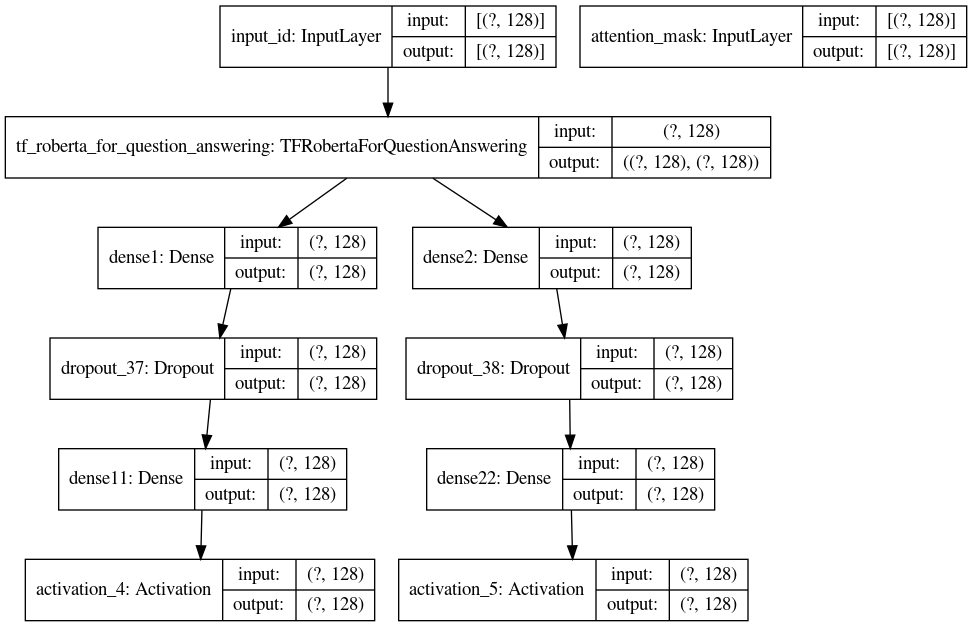

In [21]:
tf.keras.utils.plot_model(model, 'Model.png',show_shapes=True)

In [22]:
input_data = (input_ids,attention_mask)
output_data = (start_tokens,end_tokens)

val = (input_ids_val,attention_mask_val)
output_val = (start_tokens_val,end_tokens_val)
val_data = (val,output_val)

## Model parameters and compiling

In [23]:
opt = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
model.compile(optimizer=opt,loss='categorical_crossentropy')

In [24]:
train_dataset = tf.data.Dataset.from_tensor_slices((input_data, output_data)).shuffle(buffer_size=1024).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices(val_data).batch(32)

In [25]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="model2.hdf5",
    save_weights_only=True,
    monitor='val_loss',
    mode="min",
    save_best_only=True)

# Model training and validation

In [26]:
model.fit(train_dataset,epochs=5,validation_data=val_dataset,callbacks=model_checkpoint_callback)

Epoch 1/5
687/687 [==============================] - 364s 530ms/step - loss: 6.9184 - activation_4_loss: 2.4611 - activation_5_loss: 4.4522 - val_loss: 5.8821 - val_activation_4_loss: 1.9769 - val_activation_5_loss: 3.9001
Epoch 2/5
687/687 [==============================] - 362s 527ms/step - loss: 5.7699 - activation_4_loss: 2.0179 - activation_5_loss: 3.7470 - val_loss: 5.0815 - val_activation_4_loss: 1.9332 - val_activation_5_loss: 3.1434
Epoch 3/5
687/687 [==============================] - 362s 527ms/step - loss: 5.1800 - activation_4_loss: 1.9114 - activation_5_loss: 3.2636 - val_loss: 4.4805 - val_activation_4_loss: 1.7943 - val_activation_5_loss: 2.6813
Epoch 4/5
687/687 [==============================] - 362s 526ms/step - loss: 4.6361 - activation_4_loss: 1.7723 - activation_5_loss: 2.8589 - val_loss: 4.0532 - val_activation_4_loss: 1.6964 - val_activation_5_loss: 2.3519
Epoch 5/5
687/687 [==============================] - 362s 527ms/step - loss: 4.1557 - activation_4_loss: 1.6

## I ran model only for 5 epochs. As you can see as epochs progress train and validation loss are getting REDUCED. Hyper parameter tuning and more epochs would bring more efficient model. Now lets see the predictions

# Test data preparation

In [27]:
test['text'] = test['text'].apply(lambda x : str(x).lower())

In [28]:
max_length=128
test1=test[["text","sentiment"]]
count = test1.shape[0]
input_ids_tes = np.zeros((count,max_length),dtype='int32')
attention_mask_tes = np.zeros((count,max_length),dtype='int32')

for i,each in tqdm(enumerate(test1.values)):
    tes = tokenizer.encode_plus(each[0],each[1],add_special_tokens=True,max_length=128,return_attention_mask=True,pad_to_max_length=True,return_tensors='tf',verbose=False)
    input_ids_tes[i] = tes['input_ids']
    attention_mask_tes[i] = tes['attention_mask']

3534it [00:01, 2054.03it/s]


# Model prediction

In [29]:
test_data=(input_ids_tes,attention_mask_tes)
start_pred , end_pred= model.predict((test_data))
start_pred.shape,end_pred.shape

((3534, 128), (3534, 128))

In [30]:
strt_tes =[]
end_tes=[]
for i in tqdm(range(start_pred.shape[0])):
    s = tf.math.argmax(start_pred[i],axis=0).numpy()
    e = tf.math.argmax(end_pred[i],axis=0).numpy()
    strt_tes.append(s)
    end_tes.append(e)
print(len(strt_tes),len(end_tes)) 

pred_values = []
for i in tqdm(range(len(strt_tes))):
    index1 = strt_tes[i]
    index2 = end_tes[i] +2
    pred = input_ids_tes[i][index1:index2]
    mystring = tokenizer.decode(pred)
    pred_values.append(mystring)

100%|██████████| 3534/3534 [00:00<00:00, 40368.40it/s]

3534 3534


In [31]:
pred_values1=[i.split("</s>")[0] for i in pred_values] 

In [35]:
pred_values1[0:5]

[' last session of',
 ' really exciting (pre',
 ' such a shame!',
 ' happy bday',
 ' i like it!!']

In [33]:
samp_sub["selected_text"]=pred_values1

## Submission

In [34]:
samp_sub.to_csv("sub1.csv",index=False)

## I got 67% Jaccard score and it can be improved by hyperparameter tuning and running for more epochs. That's it for 2nd task guys. See you again in Task 3.